# Algoritmos de Clasificación
En este apartado se va a ver el proceso de clasificación de texto utilizando técnicas de aprendizaje supervisado. Se utilizará un data set distinto al usado hasta el momento, que cuenta con los reportes de bugs de *Java Development Tools Bug* y que servirá para predecir la clasificación que se le dará a cada uno de estos reportes.

Como siempre, se comienza definiendo los ajustes que tendrá el notebook a lo largo de su ejecución:

In [1]:
import sys, os

#Carga del archivo setup.py
%run -i ../pyenv_settings/setup.py

#Imports y configuraciones de gráficas
%run "$BASE_DIR/pyenv_settings/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# # to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# # otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)

You are working on a local system.
Files will be searched relative to "..".


A continuación, se importarán la mayoría de bibliotecas y herramientas que se utilizarán a lo largo del notebook: 

In [3]:
import matplotlib.pyplot as plt
import html 
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## Depracated:
# from sklearn.metrics import plot_confusion_matrix
## New version:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier

Ahora se importará el Dataset que se utilizará para realizar la tarea. Este se ha descargado desde el repositorio de github https://github.com/logpai/bughub/blob/master/JDT/eclipse_jdt.csv y se ha incluido en la carpeta *data* del directorio del proyecto.

In [ ]:
#Carga del archivo
file = "eclipse_jdt.csv"
file = f"{BASE_DIR}/data/eclipse_jdt.csv"

#Crear un Data Frame de pandas con este documento
df = pd.read_csv(file)

#Comprobación de que se ha procedido correctamente
print(df.columns)
df[['Issue_id','Priority','Component','Title','Description']].sample(2, random_state=42)

Se observa que el Data Frame cuenta con varias columnas correspondientes a distintos elementos o características que se deben indicar a la hora de reportar un bug para que sea más fácil para el desarrollador reproducir el error y así poder solucionarlo.

En este caso, únicamente se necesitarán las columnas *Priority*, *Component* y *Description*, pues lo que se va a tratar de hacer es clasificar, y en adelante predecir, los reportes en base a la prioridad.

## Entendiendo el Dataset
Antes de comenzar con el objeto del apartado, vamos a tratar de entender el Dataset y qué es lo que se desea con él. 

In [7]:
df.sample(1, random_state=325).T

,39288
Issue_id,261494
Priority,P3
Component,Text
Duplicated_issue,NaN
Title,[spell checking] Extra dictionaries dont appear in the UI.
Description,Created attachment 122930; This plugin adds some extra dictionaries but they dont appear in the UI.; ; Build ID: M20080911-1700; ; Steps To Reproduce:; 1. Run eclipse IDE with attached project whi...
Status,RESOLVED
Resolution,INVALID
Version,3.4.1
Created_time,2009-01-19 08:07:00 -0500


Como se indicó antes, nos vamos a centrar en las columnas Component, Priority y Description pues son las que realmente aportan información y datos necesarios para el entrenamiendo de un modelo de aprendizaje supervisado.

En la columna *Priority* se indica la prioridad que se le debería de dar al bug reportado. Esta va en una escala de P1 a P5, siendo P5 la máxima prioridad.

En *Component* se indica cuál es el componente de JVT en el cuál se ha originado el bug, en el caso anterior mostrado, se ha originado en *Text*.

En *Description* el usuario describe el bug de la forma más precisa posible.

Una vez explicado esto, si se muestra una gráfica con la distribución de prioridades que se le dan a los reportes del Dataset, se observa que la gran mayoría reciben un nivel de prioridad *P3*, eso porque es el nivel que se le asigna de forma predeterminada o porque en general los usuarios suelen dar un nivel medio la gran parte de las veces.

<Axes: xlabel='Priority'>

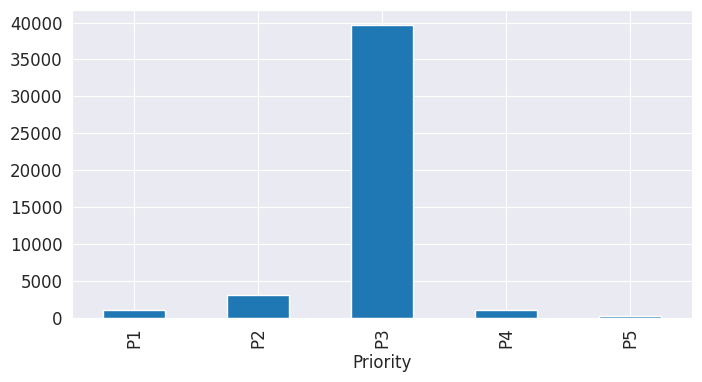

In [9]:
df['Priority'].value_counts().sort_index().plot(kind='bar')

Dle mismo modo, se puede mostrar el número de reportes asociados a cada tipo de componente.

In [10]:
df['Component'].value_counts()

Component
UI       17479
Core     13669
Debug     7542
Text      5901
APT        406
Doc        299
Name: count, dtype: int64

Una vez comprendida la estructura del Dataset, se procederá a crear el sistema de clasificación de texto.

## Construcción de un Clasificador de Texto
Un clasificador de texto se encuentra en la categoría de modelos de aprendizaje *supervisado*. Este tipo de algoritmos basan su funcionamiento en aprender las relaciones entre variables independientes y variables objetivo a través de datos etiquetados proporcionados.

En este caso, se ha escogido el método de clasificación para entrenar el modelo, que usará variables independientes como la descripción del bug para así predecir la prioridad o el componente que se le debe dar a un reporte.

### Proceso de trabajo de un modelo de aprendizaje supervisado
Se divide en dos fases: entrenamiento y predicción.

La fase de entrenamiento comienza con los datos de entrenamiento, que incluyen las observaciones que se aportan, en este caso las descripciones de los reportes de bugs, y las etiquetas asociadas, que sería lo que se desea predecir, la prioridad o componente en este caso.

En la fase de predicción, el modelo recibe un nuevo reporte en este caso, lo transforma al formato de documento que se ha utilizado durante la fase de entrenamiento y a partir de este, el modelo genera la predicción.

### Preparación de los datos
A partir de este momento, comenzará el proceso de creación de modelo y se irá documentando todo el proceso.

Como se ha visto en capitulos anteriores, es muy importante la limpieza, normalización y transformación de los datos para que estén dispuestos de forma adecuada para el análisis de estos por parte del modelo.

Como se va a usar un nuevo Dataset en el que las columnas que realmente necesitaremos serán *Priority*, *Title* y *Description* (se va a predecir la prioridad en este caso, no el componente que origina el bug), se comenzará eliminado las columnas innecesarias del datafrane y aquellas filas que contengan valores vaciós o nulos.

In [ ]:
#Selección de las columnas deseadas
df = df[['Title','Description','Priority']]
#Elimina filas sin valores
df = df.dropna()
#Une en la columna text las columnas Title y Description
df['text'] = df['Title'] + ' ' + df['Description']
#Elimina las columnas title y description
df = df.drop(columns=['Title','Description'])
df.columns

Index(['Priority', 'text'], dtype='object')

Ahora se va a usar una función *clean* que eliminará los caracteres especiales del texto.

In [12]:
def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text) 
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [14]:
df['text'] = df['text'].apply(clean)

In [ ]:
df = df[df['text'].str.len() > 50]
df.sample(2)